In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import Counter
from wordcloud import WordCloud # https://github.com/amueller/word_cloud/issues/637

### Process playlist and albums data, print column names and head, merge into one dataframe.

In [22]:
df_playlist = pd.read_csv('artists_playlist.csv')
df_albums = pd.read_csv('artists_albums_data.csv')

In [23]:
print(f'Playlist: {df_playlist.columns}\nAlbums: {df_albums.columns}')

Playlist: Index(['id', 'picture', 'artist', 'hottest', 'streams_b', 'followers_mio',
       'listeners_mio', 'scoring'],
      dtype='object')
Albums: Index(['artist_name', ' album_name', 'release_date', 'total_track'], dtype='object')


In [24]:
df_playlist = df_playlist.drop(['id', 'picture'], axis = 1)

In [25]:
df_albums = df_albums.rename(columns={'artist_name': 'artist', ' album_name': 'album_name'})
print(df_albums.head())
print(df_playlist.head())

         artist                        album_name release_date  total_track
0  Taylor Swift      Speak Now (Taylor's Version)   2023-07-07           22
1  Taylor Swift  Midnights (The Til Dawn Edition)   2023-05-26           23
2  Taylor Swift           Midnights (3am Edition)   2022-10-22           20
3  Taylor Swift                         Midnights   2022-10-21           13
4  Taylor Swift            Red (Taylor's Version)   2021-11-12           30
         artist  hottest  streams_b  followers_mio  listeners_mio  scoring
0  Taylor Swift      100      57.58          85.93         100.93      232
1         Drake       94      62.77          79.63          75.17      201
2     Bad Bunny       94      57.82          74.06          75.63      190
3    The Weeknd       94      47.46          71.36         107.28      186
4    Ed Sheeran       87      44.50         114.97          76.19      166


In [26]:
artist_album_counts = df_albums.groupby('artist')['album_name'].count().reset_index()
artist_album_counts.rename(columns={'album_name': 'album_count'}, inplace=True)

In [27]:
df_merged = pd.merge(df_playlist, artist_album_counts, on=['artist'], how='inner')
print(df_merged.shape)
print(df_merged.head())

(773, 7)
         artist  hottest  streams_b  followers_mio  listeners_mio  scoring  \
0  Taylor Swift      100      57.58          85.93         100.93      232   
1         Drake       94      62.77          79.63          75.17      201   
2     Bad Bunny       94      57.82          74.06          75.63      190   
3    The Weeknd       94      47.46          71.36         107.28      186   
4    Ed Sheeran       87      44.50         114.97          76.19      166   

   album_count  
0           24  
1           15  
2            5  
3           15  
4           13  


### Generate summary statistics, count unique artists and albums, and plot correlation matrix and histograms of key features

In [8]:
# Summary Statistics
summary_stats = df_merged.describe()

# Unique Values
unique_artists = df_merged['artist'].nunique()
unique_albums = df_albums['album_name'].nunique()

# print('Summary Statistics:')
print(summary_stats)
print('\nUnique Artists Names in df_merged:', unique_artists)
print('Unique Albums:', unique_albums)


          hottest   streams_b  followers_mio  listeners_mio     scoring  \
count  773.000000  773.000000     773.000000     773.000000  773.000000   
mean    73.695990    5.732083       8.765834      17.932329   17.945666   
std      5.934831    6.736024      11.980647      14.316436   23.890503   
min     61.000000    0.400000       0.660000       2.550000    5.000000   
25%     69.000000    2.330000       3.070000       8.870000    6.000000   
50%     73.000000    3.410000       5.140000      13.030000   10.000000   
75%     77.000000    6.330000       8.870000      22.690000   18.000000   
max    100.000000   62.770000     114.970000     107.280000  232.000000   

       album_count  
count   773.000000  
mean     13.252264  
std      15.071497  
min       1.000000  
25%       5.000000  
50%       9.000000  
75%      16.000000  
max     149.000000  

Unique Artists Names in df_merged: 773
Unique Albums: 11436


<AxesSubplot: >

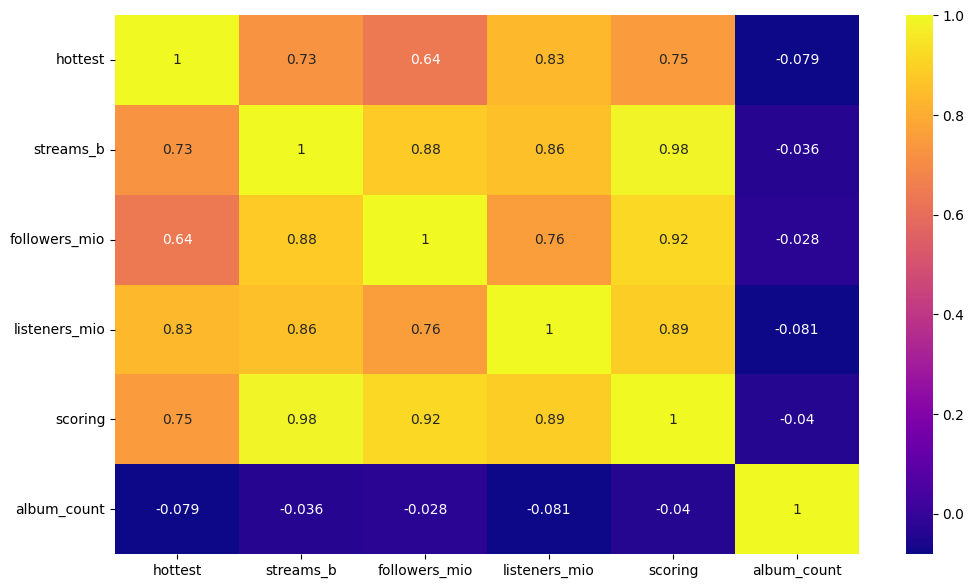

In [9]:
plt.figure(figsize=(12,7))
corr = df_merged.corr(numeric_only=True)
sns.heatmap(corr, cmap='plasma', annot=True)

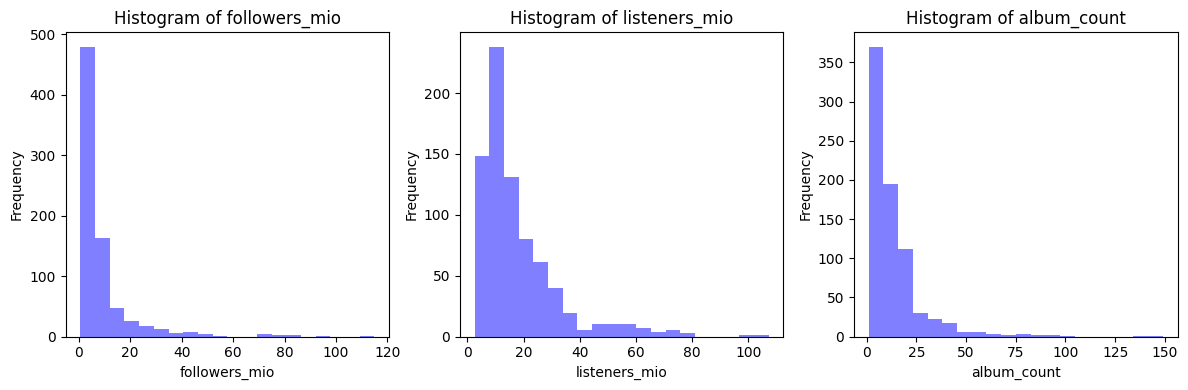

In [10]:
columns_to_plot = ['followers_mio', 'listeners_mio', 'album_count']

# Create subplots for histograms
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(12, 4))

# Create histograms for each column
for i, column in enumerate(columns_to_plot):
    axes[i].hist(df_merged[column], bins=20, alpha=0.5, color='blue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The key findings from the data analysis are:

* There are positive correlations between social connections (followers_mio and listeners_mio), sentiments (hottest and scoring), and sales performance (streams_b).
* The strongest correlation is between streams_b and scoring.
* Album count has a negative correlation with all other variables.

Below are some actionable recommendations based on these findings:

* Build social connections by engaging with fans on social media and other platforms.
* Release fewer albums to avoid fan fatigue and lower social media sentiment.

***

### Categorize artists by followers_mio and listeners_mio, and visualize the distribution of artists by category

In [11]:
# Calculate the mean and standard deviation of 'followers_mio'
mean_followers_mio = df_merged['followers_mio'].mean()
std_followers_mio = df_merged['followers_mio'].std()

# Define a function to categorize 'followers_mio' based on mean and standard deviation
def categorize_followers_mio(followers_mio):
    if followers_mio < (mean_followers_mio - std_followers_mio):
        return 'Low Followers'
    elif (mean_followers_mio - std_followers_mio) <= followers_mio < (mean_followers_mio + std_followers_mio):
        return 'Moderate Followers'
    else:
        return 'High Followers'

# Apply the categorization function to 'followers_mio' column
df_merged['followers_mio_category'] = df_merged['followers_mio'].apply(categorize_followers_mio)

color_scale = ['#0000FF', '#00FF00', '#FF0000']
category_orders_followers_mio = {'followers_mio_category': ['Low Followers', 'Moderate Followers', 'High Followers']}

# Create a DataFrame with counts for each followers_mio category
followers_mio_category_counts = df_merged['followers_mio_category'].value_counts().reset_index()
followers_mio_category_counts.columns = ['followers_mio_category', 'Artists Count']

# Create a bar chart for the followers_mio_category
followers_mio_category_fig = px.bar(followers_mio_category_counts, x='followers_mio_category', y='Artists Count',
                             title='Distribution of Artists by followers_mio Category',
                             labels={'followers_mio_category': 'Followers Category'},
                             hover_data={'Artists Count': True},
                             color='followers_mio_category',
                             category_orders=category_orders_followers_mio,
                             color_discrete_sequence=color_scale)

legend_labels = {
    'Low Followers': 'Low Followers: < (mean - std)',
    'Moderate Followers': 'Moderate Followers: (mean ± std)',
    'High Followers': 'High Followers: > (mean + std)'
}

legend_annotations = [dict(x=1.00, y=1 - 0.1 * i, xref='paper', yref='paper',
                           text=f'{legend_labels[label]}', showarrow=False)
                      for i, label in enumerate(category_orders_followers_mio['followers_mio_category'])]

followers_mio_category_fig.update_layout(annotations=legend_annotations)
print(f'Mean followers_mio: {mean_followers_mio.round(3)}')
print(f'Standard Deviation followers_mio: {std_followers_mio.round(3)}')
followers_mio_category_fig.show()


Mean followers_mio: 8.766
Standard Deviation followers_mio: 11.981


In [12]:
# Calculate the mean and standard deviation of 'listeners_mio'
mean_listeners_mio = df_merged['listeners_mio'].mean()
std_listeners_mio = df_merged['listeners_mio'].std()

# Define a function to categorize 'listeners_mio' based on mean and standard deviation
def categorize_listeners_mio(listeners_mio):
    if listeners_mio < (mean_listeners_mio - std_listeners_mio):
        return 'Low Listeners'
    elif (mean_listeners_mio - std_listeners_mio) <= listeners_mio < (mean_listeners_mio + std_listeners_mio):
        return 'Moderate Listeners'
    else:
        return 'High Listeners'

# Apply the categorization function to 'listeners_mio' column
df_merged['listeners_mio_category'] = df_merged['listeners_mio'].apply(categorize_listeners_mio)

color_scale = ['#0000FF', '#00FF00', '#FF0000']
category_orders_listeners_mio = {'listeners_mio_category': ['Low Listeners', 'Moderate Listeners', 'High Listeners']}

# Create a DataFrame with counts for each listeners_mio category
listeners_mio_category_counts = df_merged['listeners_mio_category'].value_counts().reset_index()
listeners_mio_category_counts.columns = ['listeners_mio_category', 'Artists Count']

# Create a bar chart for the listeners_mio_category
listeners_mio_category_fig = px.bar(listeners_mio_category_counts, x='listeners_mio_category', y='Artists Count',
                             title='Distribution of Artists by listeners_mio Category',
                             labels={'listeners_mio_category': 'Listeners Category'},
                             hover_data={'Artists Count': True},
                             color='listeners_mio_category',
                             category_orders=category_orders_listeners_mio,
                             color_discrete_sequence=color_scale)

legend_labels = {
    'Low Listeners': 'Low Listeners: < (mean - std)',
    'Moderate Listeners': 'Moderate Listeners: (mean ± std)',
    'High Listeners': 'High Listeners: > (mean + std)'
}

legend_annotations = [dict(x=1.00, y=1 - 0.1 * i, xref='paper', yref='paper',
                           text=f'{legend_labels[label]}', showarrow=False)
                      for i, label in enumerate(category_orders_listeners_mio['listeners_mio_category'])]

listeners_mio_category_fig.update_layout(annotations=legend_annotations)
print(f'Mean listeners_mio: {mean_listeners_mio.round(3)}')
print(f'Standard Deviation listeners_mio: {std_listeners_mio.round(3)}')
listeners_mio_category_fig.show()


Mean listeners_mio: 17.932
Standard Deviation listeners_mio: 14.316


Insights:

* The mean number of followers is 8.766 million, with a standard deviation of 11.981 million.
* The mean number of listeners is 17.932 million, with a standard deviation of 14.316 million.
* There is a strong positive correlation between followers_mio and listeners_mio, but the distribution is uneven, with a few artists having a very large number of followers and listeners.

***

### Identify top artists by followers and listeners, fit linear regression models to predict listeners and scoring based on followers, and calculate correlations.

In [13]:
percentile_99 = df_merged['followers_mio'].quantile(0.99)
top_1_percent_followers = df_merged[df_merged['followers_mio'] >= percentile_99]
top_1_percent_followers = top_1_percent_followers[[ 'artist', 'followers_mio', 'listeners_mio']]
print('\n1% artist with the most followers:')
print(top_1_percent_followers.sort_values(by='followers_mio', ascending=False))


1% artist with the most followers:
          artist  followers_mio  listeners_mio
4     Ed Sheeran         114.97          76.19
5  Ariana Grande          93.69          66.53
8  Billie Eilish          86.15          71.56
0   Taylor Swift          85.93         100.93
1          Drake          79.63          75.17
7         Eminem          76.47          63.86
6  Justin Bieber          74.19          72.71
2      Bad Bunny          74.06          75.63


In [14]:
percentile_99 = df_merged['listeners_mio'].quantile(0.99)
top_1_percent_followers = df_merged[df_merged['listeners_mio'] >= percentile_99]
top_1_percent_followers = top_1_percent_followers[[ 'artist', 'followers_mio', 'listeners_mio']]
print('\n1% artist with the most listeners:')
print(top_1_percent_followers.sort_values(by='listeners_mio', ascending=False))


1% artist with the most listeners:
           artist  followers_mio  listeners_mio
3      The Weeknd          71.36         107.28
0    Taylor Swift          85.93         100.93
13       Dua Lipa          41.52          76.20
4      Ed Sheeran         114.97          76.19
10        Rihanna          57.79          76.05
2       Bad Bunny          74.06          75.63
1           Drake          79.63          75.17
6   Justin Bieber          74.19          72.71


Fit a linear regression model to the relationship between number of followers and number of listeners, and plot the results with correlation coefficient

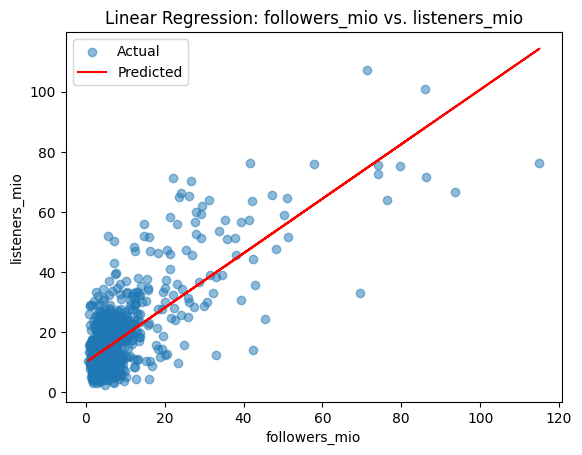

Intercept: 9.983816274600326
Coefficient: 0.9067604910476471
Correlation: 0.7588185617159712


In [15]:
model = LinearRegression()

X = df_merged[['followers_mio']]
y = df_merged['listeners_mio']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('followers_mio')
plt.ylabel('listeners_mio')
plt.title('Linear Regression: followers_mio vs. listeners_mio')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

correlation = df_merged['followers_mio'].corr(df_merged['listeners_mio'])
print(f'Correlation: {correlation}')

Fit a linear regression model to the relationship between number of followers and scoring, and plot the results with correlation coefficient

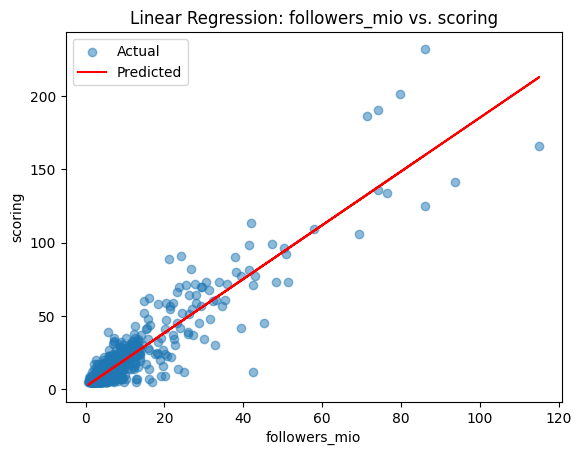

Intercept: 1.8791296371886368
Coefficient: 1.8328587838018038
Correlation: 0.9191449047135046


In [16]:
model = LinearRegression()

X = df_merged[['followers_mio']]
y = df_merged['scoring']
model.fit(X, y)

predictions = model.predict(X)

plt.scatter(X, y, label='Actual', alpha=0.5)
plt.plot(X, predictions, color='red', label='Predicted')
plt.xlabel('followers_mio')
plt.ylabel('scoring')
plt.title('Linear Regression: followers_mio vs. scoring')
plt.legend()
plt.show()

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

correlation = df_merged['followers_mio'].corr(df_merged['scoring'])
print(f'Correlation: {correlation}')

Insights

* The top 1% of artists with the most followers includes globally recognized names such as Ed Sheeran, Ariana Grande, Billie Eilish, and Taylor Swift.
* The top 1% of artists with the most listeners includes artists like The Weeknd, Taylor Swift, Dua Lipa, and Ed Sheeran.
* Interestingly, some artists like Taylor Swift have significantly more followers (85.93 million) than listeners (100.93 million), similarly, Ed Sheeran has more followers (114.97 million) than listeners (76.19 million).


Correlations

* There is a positive correlation between followers and listeners, but it is not perfect. This means that artists with more followers tend to have more listeners, but there are also cases of artists with more followers than listeners and vice versa.
* Some artists have more followers than listeners because they are very popular on social media, but their music is not as widely listened to. Other artists have more listeners than followers because their music is very popular, but they are not as active on social media.

Actionable Recommendations

* Artists with more followers than listeners should focus on engaging with their audience on social media and encouraging them to listen to their music.
* Artists with more listeners than followers should focus on building their social media presence and connecting with their fans.
***

### Analyze the distribution of artists by album count and generate visualizations to understand the trends

In [30]:
# Group by 'artist' and count the number of albums

print(df_merged.sort_values(by='album_count', ascending=False).loc[:, ['artist', 'album_count']])

              artist  album_count
615  Louis Armstrong          149
250       Gucci Mane          141
574    John Williams           98
352      Hans Zimmer           97
297   Joan Sebastian           90
..               ...          ...
370   Tanishk Bagchi            1
366       AP Dhillon            1
546            Ezhel            1
345       Nio Garcia            1
339           Offset            1

[773 rows x 2 columns]


In [31]:
# Filter artists with more than 1 track_count
filtered_df = artist_album_counts[artist_album_counts['album_count'] > 1]

# Create a Histogram
histogram_fig = go.Figure(data=[
    go.Histogram(
        x=filtered_df['album_count'],
        nbinsx=500,
        marker_color='blue',)])

histogram_fig.update_layout(
    title='Distribution of Artists by Albums Count (more than 1 Albums)',
    xaxis=dict(title='Albums Count Range'),
    yaxis=dict(title='Number of Artists'),
    showlegend=False,
    bargap=0.1)

histogram_fig.show()

html_file = 'album_count_range.html'

if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')


HTML file "album_count_range.html" already exists.


In [32]:
# Clean the artist names to remove special characters
artist_album_counts['cleaned_artist'] = artist_album_counts['artist'].str.replace('[$]', 'S', regex=True)

# Filter artists with more than 50 album_count
df_filtered_5 = artist_album_counts[artist_album_counts['album_count'] > 50]

fig = px.bar(df_filtered_5, x='cleaned_artist', y='album_count',
             labels={'cleaned_artist': 'Artist', 'album_count': 'Album Count'},
             title='Album Counts by Artist (more than 50 Albums)')
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

html_file = 'album_caunts.html'

if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "album_caunts.html" already exists.


In [20]:
fig = px.treemap(
    df_filtered_5,
    path=['cleaned_artist'],
    values='album_count',
    custom_data=['cleaned_artist', 'album_count'])


fig.update_traces(
    hovertemplate='<b>Artist:</b> %{customdata[0]}<br><b>Album Count:</b> %{customdata[1]}<br>')

fig.update_layout(
    title='Treemap of Album Counts by Artist',
    margin=dict(l=0, r=0, b=0, t=30))

fig.show()

html_file = 'treemap.html'

if not os.path.exists(html_file):
    pio.write_html(histogram_fig, file=html_file)
    print(f'HTML file "{html_file}" has been saved.')
else:
    print(f'HTML file "{html_file}" already exists.')

HTML file "treemap.html" already exists.


The: 1637
Brahms:: 800
Edition): 631
&: 579
-: 456
Live: 440
2: 403
(Deluxe: 399
the: 336
(Deluxe): 335
A: 319
Op.: 311
Piano: 305
Vol.: 297
of: 288
Of: 279
1: 277
In: 267
Version): 238
No.: 227
in: 220
(Original: 213
Motion: 203
Soundtrack): 202
(Live): 190
Picture: 189
De: 186
and: 182
3: 181
Love: 165
El: 159
for: 159
(Expanded: 152
/: 151
To: 145
Brahms: 144
a: 142
You: 140
From: 139
I: 139
(Remastered): 138
Vivo): 134
Sonatas: 133
At: 131
My: 128
La: 128
Me: 126
Music: 125
And: 125
4: 123
Anniversary: 122
On: 117
Is: 116
Remaster): 116
Symphony: 114
Violin: 112
(Ao: 107
de: 106
Vivo: 105
All: 104
Christmas: 102
Complete: 102
Nos.: 102
En: 100
from: 100
No: 98
For: 96
Life: 91
(Live: 91
Los: 89
Works: 89
Edition: 88
World: 86
It: 85
Songs: 85
Album: 83
Symphonies: 83
to: 81
by: 81
One: 81
Concerto: 81
Deluxe: 79
II: 72
at: 71
Con: 70
(Remastered: 67
on: 65
Cello: 64
New: 60
Mi: 60
Sessions: 58
Variations: 58
Night: 57
Time: 57
Louis: 57
King: 56
String: 56
Amor: 54
We: 53
Your: 52


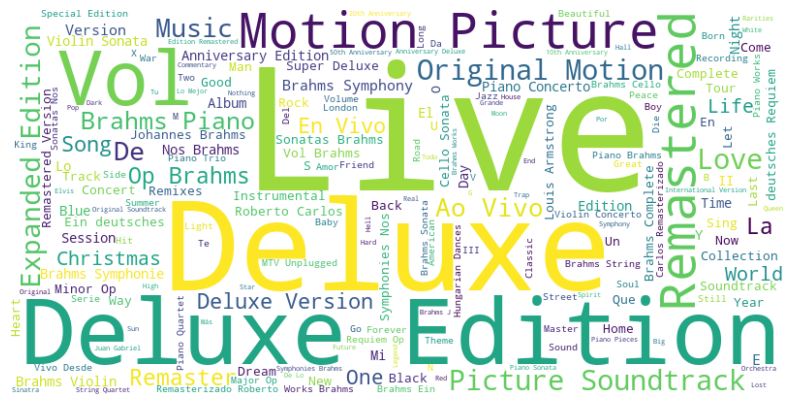

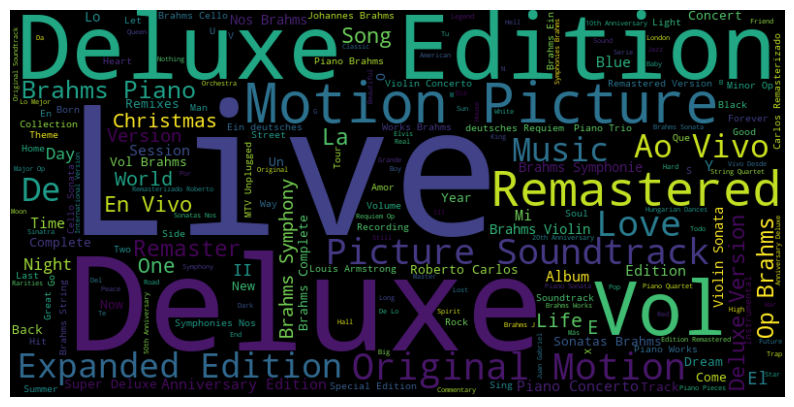

In [21]:
# Function to generate and display a word cloud
def generate_wordcloud(text, background_color):
    wordcloud = WordCloud(width=800, height=400, background_color=background_color).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Concatenate all track_names into a single string
all_track_names = ' '.join(df_albums['album_name'].astype(str))
# words_to_remove = ['feat', 'remix', 'ft', 'ft.', "'", '.', '-', '&', '[', ']',
#                     '(with', 'Edition)']
# for word in words_to_remove:
#     all_track_names = all_track_names.replace(word, "")

word_counts = Counter(all_track_names.split())
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
for word, count in sorted_word_counts.items():
    print(f'{word}: {count}')

# Generate and display the word cloud
generate_wordcloud(all_track_names, 'white')
generate_wordcloud(all_track_names, 'black')

#### Top Artists and Their Popular Tracks:

* The analysis identifies top artists, such as Taylor Swift, Drake, and The Weeknd, based on the number of popular tracks they have in the dataset. For example, Taylor Swift has 44 popular tracks in the dataset, showcasing her strong presence in popular music.

#### Word Frequency in Track Names:

* The analysis reveals the frequency of specific words in track names, indicating which words are commonly used in song titles.
* Words like "Love," "Girl," and "You" are among the most frequently used words in track names.

#### Recommendations:

* Artist Collaboration: Explore collaboration opportunities with the top artists identified in the analysis. Collaborative tracks can attract the fanbases of both artists, potentially increasing listenership.

* Playlist and Marketing Strategies: Incorporate popular words from track names into playlist titles, descriptions, and marketing materials. This can help create a connection between the playlist and the themes found in popular songs.